In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from scipy import stats

## Justification of target variables and creation of target vector

D'après nos recherches, les critères les plus importants pour quantifier la qualité d'une soudure en acier sont sa force, sa résistance au chocs et sa ductilité, car une soudure doit être capable de résister à une grande force, d'encaisser des chocs importants, ou même de se tordre sans rompre.

Nous avons donc identifié 4 variables qui représentent le mieux ces critères:

- `La Résistance à la Traction Ultime` (Ultimate Tensile Strength / MPa): Elle représente la contrainte maximale que la soudure peut supporter avant de se rompre.
- `La Résilience Charpy` (Charpy Impact Toughness / J): Elle mesure la capacité de la soudure à absorber un choc violent sans se rompre. Une valeur élevée indique une bonne résistance à la rupture fragile, ce qui est crucial pour la sécurité.
- `L'Allongement` (Elongation / %) : Cette valeur indique dans quelle mesure la soudure peut s'étirer et se déformer plastiquement avant de casser. Elle quantifie la ductilité de la soudure, c'est-à-dire sa capacité à se plier sans rompre.
- `La Striction` (Reduction of Area / %) : Similaire à l'allongement, cette mesure quantifie également la ductilité de la soudure en mesurant la réduction de sa section transversale au point de rupture. Une valeur élevée est synonyme d'un matériau ductile.

Calcul du Score de Qualité:

Pour créer une variable cible unique, nous allons d'abord normaliser chacune de ces quatre valeurs sur une échelle commune (de 0 à 1) afin qu'elles soient comparables. Ensuite, nous calculerons un score de qualité en faisant la moyenne de ces quatre indicateurs, en accordant 33% du score à La Résistance à la Traction Ultime qui représente la force, 33% du score à la La Résilience Charpy qui représente la résistance aux chocs, et 34% à la combinaison de l'Allongement et de la Striction qui représentent la ductilité de la soudure.

La formule pour le score de qualité sera donc la suivante :

Score de Qualité = 0.33 * (UTS_normalisée) + 0.33 * (Résilience_normalisée) + 0.34 * ((Allongement_normalisé) + (Striction_normalisée))

Où :

- UTS_normalisée est la valeur normalisée de la Résistance à la Traction Ultime.
- Résilience_normalisée est la valeur normalisée de la Résilience Charpy.
- Allongement_normalisé est la valeur normalisée de l'Allongement.
- Striction_normalisée est la valeur normalisée de la Striction.

Ce Score de Qualité sera notre variable cible (target). Un score plus élevé indiquera une soudure de meilleure qualité globale.

In [4]:
column_names = [
    'carbon_wt_pct',                    #1
    'silicon_wt_pct',                   #2
    'manganese_wt_pct',                 #3
    'sulphur_wt_pct',                   #4
    'phosphorus_wt_pct',                #5
    'nickel_wt_pct',                    #6
    'chromium_wt_pct',                  #7
    'molybdenum_wt_pct',                #8
    'vanadium_wt_pct',                  #9
    'copper_wt_pct',                    #10
    'cobalt_wt_pct',                    #11
    'tungsten_wt_pct',                  #12
    'oxygen_ppm',                       #13
    'titanium_ppm',                     #14
    'nitrogen_ppm',                     #15
    'aluminium_ppm',                    #16
    'boron_ppm',                        #17
    'niobium_ppm',                      #18
    'tin_ppm',                          #19
    'arsenic_ppm',                      #20
    'antimony_ppm',                     #21
    'current_a',                        #22
    'voltage_v',                        #23
    'ac_dc',                            #24
    'electrode_polarity',               #25
    'heat_input_kj_per_mm',             #26
    'interpass_temp_c',                 #27
    'weld_type',                        #28
    'pwht_temp_c',                      #29
    'pwht_time_h',                      #30
    'yield_strength_mpa',               #31
    'ultimate_tensile_strength_mpa',    #32
    'elongation_pct',                   #33
    'reduction_area_pct',               #34
    'charpy_temp_c',                    #35
    'charpy_toughness_j',               #36
    'hardness_kg_per_mm2',              #37
    'fatt50_pct',                       #38
    'primary_ferrite_pct',              #39
    'ferrite_second_phase_pct',         #40
    'acicular_ferrite_pct',             #41
    'martensite_pct',                   #42
    'ferrite_carbide_aggregate_pct',    #43
    'weld_id'                           #44
]

# Load the data
data = pd.read_csv('data/welddb.data', sep=r'\s+', names=column_names, na_values='N')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   carbon_wt_pct                  1652 non-null   float64
 1   silicon_wt_pct                 1652 non-null   float64
 2   manganese_wt_pct               1652 non-null   float64
 3   sulphur_wt_pct                 1648 non-null   object 
 4   phosphorus_wt_pct              1642 non-null   float64
 5   nickel_wt_pct                  697 non-null    float64
 6   chromium_wt_pct                784 non-null    float64
 7   molybdenum_wt_pct              793 non-null    object 
 8   vanadium_wt_pct                928 non-null    object 
 9   copper_wt_pct                  578 non-null    object 
 10  cobalt_wt_pct                  129 non-null    object 
 11  tungsten_wt_pct                75 non-null     object 
 12  oxygen_ppm                     1256 non-null   f

In [5]:
# List of columns to be used for the targets DataFrame
columns_to_keep = [
    'ultimate_tensile_strength_mpa',
    'charpy_toughness_j',
    'elongation_pct',
    'reduction_area_pct'
]

# 1. Create the targets DataFrame with the specified columns
targets_df = data[columns_to_keep].copy()

# 2. Create the features DataFrame with the remaining columns
features_df = data.drop(columns=columns_to_keep).copy()

print("--- Targets DataFrame ---")
targets_df.info()
print("\\n" + "="*30 + "\\n")
print("--- Features DataFrame ---")
features_df.info()

--- Targets DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ultimate_tensile_strength_mpa  738 non-null    float64
 1   charpy_toughness_j             879 non-null    float64
 2   elongation_pct                 700 non-null    float64
 3   reduction_area_pct             705 non-null    float64
dtypes: float64(4)
memory usage: 51.8 KB
\n==============================\n
--- Features DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1652 entries, 0 to 1651
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   carbon_wt_pct                  1652 non-null   float64
 1   silicon_wt_pct                 1652 non-null   float64
 2   manganese_wt_pct               1652 non-null   float6

In [6]:
def clean_numeric(val):
    """Convert strings like '<0.002' to numeric values"""
    if pd.isna(val):
        return np.nan
    if isinstance(val, str):
        if val.startswith('<'):
            return float(val[1:]) * 0.5  # Use half the detection limit
        elif val.startswith('>'):
            return float(val[1:]) * 1.5  # Use 1.5x the upper limit
    return val

# Apply cleaning to all numeric columns (features and targets)
for col in column_names:
    if col in targets_df.columns:
        targets_df[col] = targets_df[col].apply(clean_numeric)
        targets_df[col] = pd.to_numeric(targets_df[col], errors='coerce')


print(targets_df.head())

   ultimate_tensile_strength_mpa  charpy_toughness_j  elongation_pct  \
0                          466.0                 NaN            31.9   
1                            NaN               100.0             NaN   
2                          456.0               100.0            35.2   
3                          498.0                 NaN            31.2   
4                            NaN               100.0             NaN   

   reduction_area_pct  
0                80.6  
1                 NaN  
2                80.6  
3                80.6  
4                 NaN  


In [7]:
non_missing_counts = targets_df.notna().sum(axis=1)

feature_distribution = non_missing_counts.value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)

print("Count of datapoints by number of available features:")
print("-" * 55)
print(feature_distribution)
print("-" * 55)

Count of datapoints by number of available features:
-------------------------------------------------------
0    145
1    787
2     59
3    527
4    134
Name: count, dtype: int64
-------------------------------------------------------


On enlève tout ceux avec aucun feature, et on impute les autres avec la moyenne pour compléter. Utiliser une imputation simple avec la médiane réduit trop l'écart type de nos scores et les rend moins représentatifs ce qui rendra l'apprentissage compliqué.

Notre problème majeur est que beaucoup de données n'ont qu'un des 4 features de qualité alors qu'on aimerait en avoir au moins 2 pour faire une imputation plus robuste. On va être obligé de faire l'entrainement sur moins de données du coup...

In [8]:
rows_to_keep_index = targets_df.dropna(thresh=2).index

print(f"Original number of rows: {len(targets_df)}")
print(f"Number of rows to keep (with at least 2 target values): {len(rows_to_keep_index)}\n")


# 2. Filter BOTH DataFrames using this same index
targets_df_filtered = targets_df.loc[rows_to_keep_index]
features_df_filtered = features_df.loc[rows_to_keep_index]

imputer = KNNImputer(n_neighbors=5)

imputed_data_np = imputer.fit_transform(targets_df_filtered)

targets_df_final = pd.DataFrame(imputed_data_np,
                                columns=targets_df_filtered.columns,
                                index=targets_df_filtered.index)

Original number of rows: 1652
Number of rows to keep (with at least 2 target values): 720



In [9]:
non_missing_counts = targets_df_final.notna().sum(axis=1)

feature_distribution = non_missing_counts.value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)

print("Count of datapoints by number of available features:")
print("-" * 55)
print(feature_distribution)
print("-" * 55)

Count of datapoints by number of available features:
-------------------------------------------------------
0      0
1      0
2      0
3      0
4    720
Name: count, dtype: int64
-------------------------------------------------------


In [10]:
def calculate_quality_score(df_imputed: pd.DataFrame) -> pd.Series:
    """
    Calcule un score de qualité pour chaque soudure à partir d'un DataFrame.

    La fonction effectue les étapes suivantes :
    1. Normalise les 4 colonnes de caractéristiques (UTS, Résilience, Allongement, Striction)
       sur une échelle de 0 à 1 (Min-Max scaling).
    2. Applique une formule de pondération pour calculer un score de qualité final.
    3. Renvoie les scores sous forme de Série pandas.

    Args:
        df_imputed (pd.DataFrame): Un DataFrame contenant les colonnes requises,
                                   sans aucune valeur manquante. Les colonnes attendues sont :
                                   'ultimate_tensile_strength_mpa', 'charpy_toughness_j',
                                   'elongation_pct', 'reduction_area_pct'.

    Returns:
        pd.Series: Une Série pandas contenant le score de qualité calculé pour chaque ligne.
    """
    # --- Étape 1: Normalisation Min-Max ---
    # La méthode la plus simple avec pandas est (valeur - min) / (max - min)
    df_normalized = (df_imputed - df_imputed.min()) / (df_imputed.max() - df_imputed.min())

    # --- Étape 2: Application de la formule de score pondérée ---
    weight_uts = 0.33
    weight_toughness = 0.33
    weight_ductility = 0.34

    # Extraction des colonnes normalisées
    uts_norm = df_normalized['ultimate_tensile_strength_mpa']
    toughness_norm = df_normalized['charpy_toughness_j']
    elongation_norm = df_normalized['elongation_pct']
    reduction_norm = df_normalized['reduction_area_pct']

    # Calcul du score
    # La ductilité est la moyenne des deux indicateurs de ductilité
    ductility_score = (elongation_norm + reduction_norm) / 2
    
    quality_scores = (weight_uts * uts_norm +
                      weight_toughness * toughness_norm +
                      weight_ductility * ductility_score)

    # Renommer la série pour plus de clarté
    quality_scores.name = "quality_score"
    
    return quality_scores

In [11]:
Y = calculate_quality_score(targets_df_final)
Y.head()

0    0.639884
2    0.656446
3    0.650376
5    0.645338
6    0.658735
Name: quality_score, dtype: float64

In [12]:
print(f"Moyenne des scores de qualité : {Y.mean()}")
print(f"Médiane des scores de qualité : {Y.median()}")
print(f"Écart-type des scores de qualité : {Y.std()}")

Moyenne des scores de qualité : 0.5851750438479345
Médiane des scores de qualité : 0.6312573390151516
Écart-type des scores de qualité : 0.09771579621473715


## Features Preprocessing

On a maintenant nos 720 points sur lesquels on va pouvoir travailler avec leur target `Y` et leurs features raw `features_df_filtered`.

Il faut preprocess nos features avant de se lancer dans les différentes méthodes de régression

In [13]:
def clean_numeric(val):
    """Convert strings like '<0.002' to numeric values"""
    if pd.isna(val):
        return np.nan
    if isinstance(val, str):
        if val.startswith('<'):
            return float(val[1:]) * 0.5  # Use half the detection limit
        elif val.startswith('>'):
            return float(val[1:]) * 1.5  # Use 1.5x the upper limit
    return val

# Separate numeric and categorical features
categorical_features = ['ac_dc', 'electrode_polarity', 'weld_type']
numeric_feature_cols = [col for col in column_names if col not in categorical_features and col != 'weld_id']

# Apply cleaning to all numeric columns (features and targets)
for col in numeric_feature_cols:
    if col in features_df_filtered.columns:
        features_df_filtered[col] = features_df_filtered[col].apply(clean_numeric)
        features_df_filtered[col] = pd.to_numeric(features_df_filtered[col], errors='coerce')

print(features_df_filtered.info())

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 0 to 1640
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   carbon_wt_pct                  720 non-null    float64
 1   silicon_wt_pct                 720 non-null    float64
 2   manganese_wt_pct               720 non-null    float64
 3   sulphur_wt_pct                 716 non-null    float64
 4   phosphorus_wt_pct              714 non-null    float64
 5   nickel_wt_pct                  344 non-null    float64
 6   chromium_wt_pct                376 non-null    float64
 7   molybdenum_wt_pct              351 non-null    float64
 8   vanadium_wt_pct                441 non-null    float64
 9   copper_wt_pct                  288 non-null    float64
 10  cobalt_wt_pct                  75 non-null     float64
 11  tungsten_wt_pct                75 non-null     float64
 12  oxygen_ppm                     508 non-null    float64

In [14]:
# Convert categorical features to dummy variables
print("\nConverting categorical features to dummy variables...")
categorical_dummies = []
for cat_col in categorical_features:
    if cat_col in features_df_filtered.columns:
        # Create dummy variables, drop first to avoid multicollinearity
        dummies = pd.get_dummies(features_df_filtered[cat_col], prefix=cat_col, drop_first=True, dummy_na=True, dtype=float)
        categorical_dummies.append(dummies)
        print(f"  {cat_col}: {len(dummies.columns)} dummy variable(s) created")

# Combine all dummies into one DataFrame
if categorical_dummies:
    categorical_df = pd.concat(categorical_dummies, axis=1)
    dummy_feature_names = categorical_df.columns.tolist()
else:
    categorical_df = pd.DataFrame()
    dummy_feature_names = []

print(f"\nNumeric features ({len(numeric_feature_cols)}):")
print(f"{numeric_feature_cols}")
print(f"\nCategorical dummy features ({len(dummy_feature_names)}):")
print(f"{dummy_feature_names}\n\n")

# complete dataframe with numeric_feature_cols df and categorical_df
with_dummies = features_df_filtered.copy()
with_dummies.drop(columns=categorical_features, inplace=True)
with_dummies = pd.concat([with_dummies, categorical_df], axis=1)

print(with_dummies.info())


Converting categorical features to dummy variables...
  ac_dc: 2 dummy variable(s) created
  electrode_polarity: 3 dummy variable(s) created
  weld_type: 10 dummy variable(s) created

Numeric features (40):
['carbon_wt_pct', 'silicon_wt_pct', 'manganese_wt_pct', 'sulphur_wt_pct', 'phosphorus_wt_pct', 'nickel_wt_pct', 'chromium_wt_pct', 'molybdenum_wt_pct', 'vanadium_wt_pct', 'copper_wt_pct', 'cobalt_wt_pct', 'tungsten_wt_pct', 'oxygen_ppm', 'titanium_ppm', 'nitrogen_ppm', 'aluminium_ppm', 'boron_ppm', 'niobium_ppm', 'tin_ppm', 'arsenic_ppm', 'antimony_ppm', 'current_a', 'voltage_v', 'heat_input_kj_per_mm', 'interpass_temp_c', 'pwht_temp_c', 'pwht_time_h', 'yield_strength_mpa', 'ultimate_tensile_strength_mpa', 'elongation_pct', 'reduction_area_pct', 'charpy_temp_c', 'charpy_toughness_j', 'hardness_kg_per_mm2', 'fatt50_pct', 'primary_ferrite_pct', 'ferrite_second_phase_pct', 'acicular_ferrite_pct', 'martensite_pct', 'ferrite_carbide_aggregate_pct']

Categorical dummy features (15):
['ac

In [15]:
categorical_nan_cols = ['ac_dc_nan', 'electrode_polarity_nan', 'weld_type_nan']

for col in categorical_nan_cols:
    print(f"Column: {col} has {int(with_dummies[col].sum())} Nan values out of 720")

Column: ac_dc_nan has 102 Nan values out of 720
Column: electrode_polarity_nan has 52 Nan values out of 720
Column: weld_type_nan has 0 Nan values out of 720


Il n'y a pas trop de Nan values sur ces trois colonnes donc pas besoin d'en enlever une

In [16]:
# --------- Remove numeric features with too many missing values (>50%) ---------
missing_ratio = with_dummies.isna().mean()
cols = [c for c in with_dummies.columns if (missing_ratio[c] <= 0.5) or (c in dummy_feature_names)]
ready_dataset = with_dummies[cols].copy()

print(ready_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 0 to 1640
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   carbon_wt_pct           720 non-null    float64
 1   silicon_wt_pct          720 non-null    float64
 2   manganese_wt_pct        720 non-null    float64
 3   sulphur_wt_pct          716 non-null    float64
 4   phosphorus_wt_pct       714 non-null    float64
 5   chromium_wt_pct         376 non-null    float64
 6   vanadium_wt_pct         441 non-null    float64
 7   oxygen_ppm              508 non-null    float64
 8   titanium_ppm            407 non-null    float64
 9   nitrogen_ppm            492 non-null    float64
 10  aluminium_ppm           408 non-null    float64
 11  niobium_ppm             395 non-null    float64
 12  current_a               607 non-null    float64
 13  voltage_v               607 non-null    float64
 14  heat_input_kj_per_mm    720 non-null    float6

In [17]:
# Compter les valeurs manquantes par ligne
missing_per_row = ready_dataset.isnull().sum(axis=1)

# Garder seulement les lignes avec ≤ 30% de valeurs manquantes
threshold_pct = 30
threshold_count = (threshold_pct / 100) * ready_dataset.shape[1]

# Cleaned dataframe
ready_dataset = ready_dataset[missing_per_row <= threshold_count]
indices_to_keep = ready_dataset.index

# print new dataframe
print(ready_dataset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 0 to 1640
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   carbon_wt_pct           720 non-null    float64
 1   silicon_wt_pct          720 non-null    float64
 2   manganese_wt_pct        720 non-null    float64
 3   sulphur_wt_pct          716 non-null    float64
 4   phosphorus_wt_pct       714 non-null    float64
 5   chromium_wt_pct         376 non-null    float64
 6   vanadium_wt_pct         441 non-null    float64
 7   oxygen_ppm              508 non-null    float64
 8   titanium_ppm            407 non-null    float64
 9   nitrogen_ppm            492 non-null    float64
 10  aluminium_ppm           408 non-null    float64
 11  niobium_ppm             395 non-null    float64
 12  current_a               607 non-null    float64
 13  voltage_v               607 non-null    float64
 14  heat_input_kj_per_mm    720 non-null    float6

## Outliers, missing data part 2 and imputation

In [18]:
def detect_outliers_iqr(df, numeric_cols, multiplier=1.5):
    """
    Detect outliers using Interquartile Range (IQR) method
    
    Parameters:
    - df: DataFrame
    - numeric_cols: list of numeric columns
    - multiplier: IQR multiplier (1.5 standard, 3 for extreme outliers)
    
    Returns:
    - outliers_info: DataFrame with outlier statistics
    - outlier_mask: boolean mask of rows with outliers
    """
    outlier_counts = {}
    outlier_indices = set()
    
    for col in numeric_cols:
        if col in df.columns and df[col].notna().sum() > 0:
            try:
                # Convert to numeric, coercing errors to NaN
                col_data = pd.to_numeric(df[col], errors='coerce')
                if col_data.notna().sum() > 0:
                    Q1 = col_data.quantile(0.25)
                    Q3 = col_data.quantile(0.75)
                    IQR = Q3 - Q1
                    
                    lower_bound = Q1 - multiplier * IQR
                    upper_bound = Q3 + multiplier * IQR
                    
                    col_outliers = ((col_data < lower_bound) | (col_data > upper_bound)).sum()
                    outlier_counts[col] = col_outliers
                    
                    if col_outliers > 0:
                        outlier_indices.update(
                            df[(col_data < lower_bound) | (col_data > upper_bound)].index
                        )
                else:
                    outlier_counts[col] = 0
            except Exception as e:
                print(f"Warning: Could not process column '{col}': {e}")
                outlier_counts[col] = 0
    
    outliers_info = pd.DataFrame(list(outlier_counts.items()), 
                                  columns=['Column', 'Outlier_Count']).sort_values('Outlier_Count', ascending=False)
    
    outlier_mask = df.index.isin(outlier_indices)
    
    print("\n" + "=" * 70)
    print(f"OUTLIER DETECTION (IQR method, multiplier={multiplier})")
    print("=" * 70)
    print(outliers_info[outliers_info['Outlier_Count'] > 0].to_string())
    print(f"\nTotal rows with outliers: {outlier_mask.sum()} ({(outlier_mask.sum()/len(df))*100:.2f}%)")
    print("=" * 70)
    
    return outliers_info, outlier_mask

In [19]:
numeric_feature_cols = [col for col in ready_dataset.columns if col not in categorical_features and col != 'weld_id']
detect_outliers_iqr(ready_dataset, numeric_feature_cols, multiplier=1.5)


OUTLIER DETECTION (IQR method, multiplier=1.5)
                    Column  Outlier_Count
15        interpass_temp_c            287
29            weld_type_SA            179
19                ac_dc_DC            122
20               ac_dc_nan            102
1           silicon_wt_pct             89
7               oxygen_ppm             78
6          vanadium_wt_pct             75
8             titanium_ppm             63
23  electrode_polarity_nan             52
9             nitrogen_ppm             52
3           sulphur_wt_pct             51
14    heat_input_kj_per_mm             50
11             niobium_ppm             40
5          chromium_wt_pct             33
0            carbon_wt_pct             26
32           weld_type_TSA             24
13               voltage_v             20
18      yield_strength_mpa             17
22    electrode_polarity_0             16
4        phosphorus_wt_pct             16
10           aluminium_ppm             12
31          weld_type_ShMA  

(                    Column  Outlier_Count
 15        interpass_temp_c            287
 29            weld_type_SA            179
 19                ac_dc_DC            122
 20               ac_dc_nan            102
 1           silicon_wt_pct             89
 7               oxygen_ppm             78
 6          vanadium_wt_pct             75
 8             titanium_ppm             63
 23  electrode_polarity_nan             52
 9             nitrogen_ppm             52
 3           sulphur_wt_pct             51
 14    heat_input_kj_per_mm             50
 11             niobium_ppm             40
 5          chromium_wt_pct             33
 0            carbon_wt_pct             26
 32           weld_type_TSA             24
 13               voltage_v             20
 18      yield_strength_mpa             17
 22    electrode_polarity_0             16
 4        phosphorus_wt_pct             16
 10           aluminium_ppm             12
 31          weld_type_ShMA             10
 21    elec

In [20]:
def detect_outliers_zscore(df, numeric_cols, threshold=3):
    """
    Detect outliers using Z-score method (more aggressive)
    
    Parameters:
    - df: DataFrame
    - numeric_cols: list of numeric columns
    - threshold: z-score threshold (3 for extreme, 2.5 for stricter)
    
    Returns:
    - outliers_info: DataFrame with outlier statistics
    - outlier_mask: boolean mask of rows with outliers
    """
    outlier_counts = {}
    outlier_indices = set()
    
    for col in numeric_cols:
        if col in df.columns and df[col].notna().sum() > 1:
            try:
                # Convert to numeric, coercing errors to NaN
                col_data = pd.to_numeric(df[col], errors='coerce')
                if col_data.notna().sum() > 1:
                    z_scores = np.abs(stats.zscore(col_data.dropna()))
                    col_outliers = (z_scores > threshold).sum()
                    outlier_counts[col] = col_outliers
                    
                    if col_outliers > 0:
                        outlier_indices.update(
                            df[np.abs(stats.zscore(col_data.fillna(col_data.mean()))) > threshold].index
                        )
                else:
                    outlier_counts[col] = 0
            except Exception as e:
                print(f"Warning: Could not process column '{col}': {e}")
                outlier_counts[col] = 0
    
    outliers_info = pd.DataFrame(list(outlier_counts.items()), 
                                  columns=['Column', 'Outlier_Count']).sort_values('Outlier_Count', ascending=False)
    
    outlier_mask = df.index.isin(outlier_indices)
    
    print("\n" + "=" * 70)
    print(f"OUTLIER DETECTION (Z-score method, threshold={threshold})")
    print("=" * 70)
    print(outliers_info[outliers_info['Outlier_Count'] > 0].to_string())
    print(f"\nTotal rows with outliers: {outlier_mask.sum()} ({(outlier_mask.sum()/len(df))*100:.2f}%)")
    print("=" * 70)
    
    return outliers_info, outlier_mask

In [21]:
detect_outliers_zscore(ready_dataset, numeric_feature_cols, threshold=3)


OUTLIER DETECTION (Z-score method, threshold=3)
                    Column  Outlier_Count
23  electrode_polarity_nan             52
14    heat_input_kj_per_mm             26
32           weld_type_TSA             24
5          chromium_wt_pct             21
13               voltage_v             20
9             nitrogen_ppm             19
22    electrode_polarity_0             16
1           silicon_wt_pct             14
0            carbon_wt_pct             12
8             titanium_ppm             12
31          weld_type_ShMA             10
11             niobium_ppm              9
18      yield_strength_mpa              8
7               oxygen_ppm              7
10           aluminium_ppm              7
21    electrode_polarity_-              7
3           sulphur_wt_pct              5
4        phosphorus_wt_pct              5
28         weld_type_NGSAW              4
24          weld_type_GMAA              4
25          weld_type_GTAA              4
30           weld_type_SAA 

(                    Column  Outlier_Count
 23  electrode_polarity_nan             52
 14    heat_input_kj_per_mm             26
 32           weld_type_TSA             24
 5          chromium_wt_pct             21
 13               voltage_v             20
 9             nitrogen_ppm             19
 22    electrode_polarity_0             16
 1           silicon_wt_pct             14
 0            carbon_wt_pct             12
 8             titanium_ppm             12
 31          weld_type_ShMA             10
 11             niobium_ppm              9
 18      yield_strength_mpa              8
 7               oxygen_ppm              7
 10           aluminium_ppm              7
 21    electrode_polarity_-              7
 3           sulphur_wt_pct              5
 4        phosphorus_wt_pct              5
 28         weld_type_NGSAW              4
 24          weld_type_GMAA              4
 25          weld_type_GTAA              4
 30           weld_type_SAA              4
 15        

In [22]:
# Mark outliers as NaN for imputation
def mark_outliers_as_nan(df, numeric_cols, threshold=3):
    df_marked = df.copy()
    outliers_count = {}
    
    for col in numeric_cols:
        if col in df_marked.columns:
            try:
                # Convert to numeric
                col_data = pd.to_numeric(df_marked[col], errors='coerce')
                
                if col_data.notna().sum() > 1:
                    # Calculate z-scores
                    z_scores = np.abs(stats.zscore(col_data.fillna(col_data.mean())))
                    
                    # Mark outliers as NaN
                    outlier_mask = z_scores > threshold
                    n_outliers = outlier_mask.sum()
                    outliers_count[col] = n_outliers
                    
                    df_marked.loc[outlier_mask, col] = np.nan
                    
                    if n_outliers > 0:
                        print(f"{col}: {n_outliers} outliers marked as NaN")
            except Exception as e:
                print(f"Error processing {col}: {e}")
    
    print(f"\nTotal outliers marked: {sum(outliers_count.values())}")
    return df_marked

# Usage
ready_dataset = mark_outliers_as_nan(ready_dataset, numeric_feature_cols, threshold=3)
print(f"\nMissing values before: {ready_dataset.isnull().sum().sum()}")
print(f"Missing values after marking outliers: {ready_dataset.isnull().sum().sum()}")

carbon_wt_pct: 12 outliers marked as NaN
silicon_wt_pct: 14 outliers marked as NaN
sulphur_wt_pct: 5 outliers marked as NaN
phosphorus_wt_pct: 5 outliers marked as NaN
chromium_wt_pct: 33 outliers marked as NaN
vanadium_wt_pct: 3 outliers marked as NaN
oxygen_ppm: 9 outliers marked as NaN
titanium_ppm: 14 outliers marked as NaN
nitrogen_ppm: 23 outliers marked as NaN
aluminium_ppm: 16 outliers marked as NaN
niobium_ppm: 19 outliers marked as NaN
voltage_v: 20 outliers marked as NaN
heat_input_kj_per_mm: 26 outliers marked as NaN
interpass_temp_c: 4 outliers marked as NaN
yield_strength_mpa: 9 outliers marked as NaN
electrode_polarity_-: 7 outliers marked as NaN
electrode_polarity_0: 16 outliers marked as NaN
electrode_polarity_nan: 52 outliers marked as NaN
weld_type_GMAA: 4 outliers marked as NaN
weld_type_GTAA: 4 outliers marked as NaN
weld_type_NGGMA: 2 outliers marked as NaN
weld_type_NGSAW: 4 outliers marked as NaN
weld_type_SAA: 4 outliers marked as NaN
weld_type_ShMA: 10 outlier

In [23]:
ready_dataset.shape

(720, 35)

In [24]:
ready_dataset.isnull().sum().sort_values(ascending=False)

chromium_wt_pct           377
niobium_ppm               344
aluminium_ppm             328
titanium_ppm              327
vanadium_wt_pct           282
nitrogen_ppm              251
oxygen_ppm                221
voltage_v                 133
current_a                 113
electrode_polarity_nan     52
heat_input_kj_per_mm       26
weld_type_TSA              24
yield_strength_mpa         18
electrode_polarity_0       16
silicon_wt_pct             14
pwht_time_h                13
pwht_temp_c                13
carbon_wt_pct              12
phosphorus_wt_pct          11
weld_type_ShMA             10
sulphur_wt_pct              9
electrode_polarity_-        7
interpass_temp_c            4
weld_type_NGSAW             4
weld_type_SAA               4
weld_type_GTAA              4
weld_type_GMAA              4
weld_type_NGGMA             2
weld_id                     0
weld_type_MMA               0
weld_type_SA                0
ac_dc_nan                   0
ac_dc_DC                    0
manganese_

In [25]:
def impute_missing_values(df, numeric_cols, method='knn', n_neighbors=5):
    """
    Impute missing values AND marked outliers using different strategies
    
    Parameters:
    - df: DataFrame (with outliers already marked as NaN)
    - numeric_cols: list of numeric columns
    - method: 'knn'
    - n_neighbors: for KNN imputation
    
    Returns:
    - df_imputed: DataFrame with imputed values
    - imputation_report: report of imputation operations
    """
    df_imputed = df.copy()
    missing_before = df_imputed[numeric_cols].isnull().sum().sum()
    
    print("\n" + "=" * 70)
    print(f"IMPUTATION (method: {method})")
    print("=" * 70)
    print(f"Total missing/outlier values before imputation: {missing_before}")
    
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed[numeric_cols] = knn_imputer.fit_transform(df_imputed[numeric_cols])
    method_desc = f'KNN with {n_neighbors} neighbors'
    
    missing_after = df_imputed[numeric_cols].isnull().sum().sum()
    
    print(f"Total missing/outlier values after imputation: {missing_after}")
    print(f"Method used: {method_desc}")
    print(f"Values imputed: {missing_before - missing_after}")
    print("=" * 70)
    
    imputation_report = {
        'method': method_desc,
        'missing_before': missing_before,
        'missing_after': missing_after,
        'values_imputed': missing_before - missing_after
    }
    
    return df_imputed, imputation_report

In [26]:
ready_dataset, imputation_report = impute_missing_values(ready_dataset, numeric_feature_cols, method='knn', n_neighbors=5)


IMPUTATION (method: knn)
Total missing/outlier values before imputation: 2623
Total missing/outlier values after imputation: 0
Method used: KNN with 5 neighbors
Values imputed: 2623


## Feature Analysis

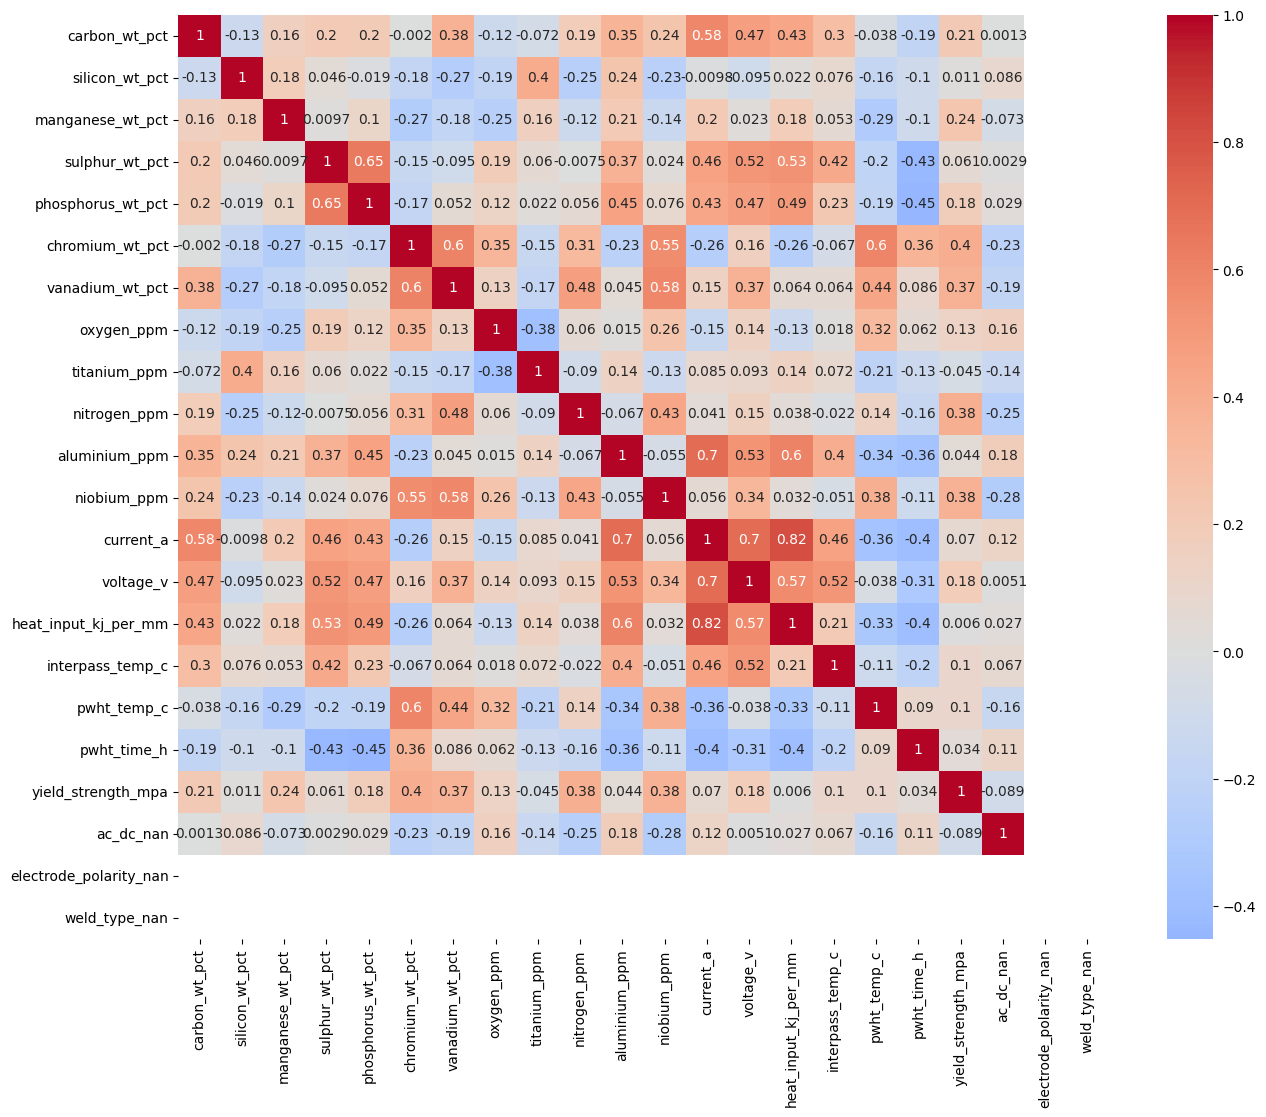

In [27]:
cat_cols = ['ac_dc_DC', 'electrode_polarity_-', 'electrode_polarity_0', 
                'weld_type_GMAA', 'weld_type_GTAA', 'weld_type_MMA', 
                'weld_type_NGGMA', 'weld_type_NGSAW', 'weld_type_SA', 
                'weld_type_SAA', 'weld_type_ShMA', 'weld_type_TSA']

ready_dataset_num = ready_dataset.drop(columns=cat_cols)

plt.figure(figsize=(15, 12))
sns.heatmap(ready_dataset_num.corr(numeric_only=True), cmap='coolwarm', center=0, annot=True)
plt.show()

### Impureté 

Observation : Sulphur (0.63) et Phosphorus (0.63) ont les plus fortes corrélations avec charpy_toughness
Justification physique : Les impuretés (S, P) sont des ductility killers en soudure. Elles créent des fragilités intergranulaires
Features à créer :

impurities_index = sulphur_wt_pct + phosphorus_wt_pct

sulphur_phosphorus_ratio = sulphur_wt_pct / (phosphorus_wt_pct + 1e-6) in case P = 0 

In [28]:
impurities_index = ready_dataset['sulphur_wt_pct'] + ready_dataset['phosphorus_wt_pct']
sulphur_phosphorus_ratio = ready_dataset['sulphur_wt_pct'] / (ready_dataset['phosphorus_wt_pct'] + 1e-6)

ready_dataset['impurities_index'] = impurities_index    
ready_dataset['sulphur_phosphorus_ratio'] = sulphur_phosphorus_ratio

### PARAMÈTRES ÉLECTRIQUES 

Observation : Current (0.72) et Voltage (0.67) ont une forte corrélation entre eux ET avec heat_input (0.87, 0.67)
Justification physique : Le courant et la tension contrôlent l'apport thermique. Heat input = (Current × Voltage × Temps) / Longueur
Features à créer :

power_input_kw = (current_a * voltage_v) / 1000 - Énergie totale

power_efficiency = heat_input_kj_per_mm / (current_a * voltage_v + 1e-6) - Efﬁcacité énergétique

current_density_proxy = current_a / voltage_v - Rapport pour refroidissement

In [29]:
power_input_kw = (ready_dataset['current_a'] * ready_dataset['voltage_v']) / 1000 
power_efficiency = ready_dataset['heat_input_kj_per_mm'] / (ready_dataset['current_a'] * ready_dataset['voltage_v'] + 1e-6) 
current_density_proxy = ready_dataset['current_a'] / ready_dataset['voltage_v'] 

ready_dataset['power_input_kw'] = power_input_kw
ready_dataset['power_efficiency'] = power_efficiency        
ready_dataset['current_density_proxy'] = current_density_proxy

###  CARBONE & MANGANÈSE

Observation : Carbon (0.27) et Manganese (0.2) ont corrélation modérée avec toughness
Justification physique :

Carbone augmente la dureté MAIS réduit la ténacité (trade-off classique)

Manganèse aide au durcissement mais peut créer de la fragilité à froid

Features à créer :

hardenability_index = carbon_wt_pct + (manganese_wt_pct / 6) - Classique Carbon Equivalent (CEQ)

carbon_manganese_ratio = carbon_wt_pct / (manganese_wt_pct + 0.1) - Équilibre C/Mn

In [30]:
hardenability_index = ready_dataset['carbon_wt_pct'] + (ready_dataset['manganese_wt_pct'] / 6) 
carbon_manganese_ratio = ready_dataset['carbon_wt_pct']/ (ready_dataset['manganese_wt_pct'] + 0.1) 

###  PARAMÈTRES THERMIQUES

Observation :

Heat_input corrélé avec current (0.87), voltage (0.67)<br>
Interpass_temp faiblement corrélé (0.041 avec toughness)

Justification physique :

Heat input contrôle la vitesse de refroidissement (affecte la microstructure) <br>
Interpass temperature ralentit le refroidissement entre passes (réduit les contraintes)

Features à créer :

cooling_rate_proxy = heat_input_kj_per_mm / (interpass_temp_c + 273) - Taux de refroidissement normalisé<br>
thermal_cycle_intensity = heat_input_kj_per_mm * (1 / (interpass_temp_c + 1)) - Intensité du cycle thermique

In [31]:
cooling_rate_proxy = ready_dataset['heat_input_kj_per_mm'] / ( ready_dataset['interpass_temp_c'] + 273) 
thermal_cycle_intensity = ready_dataset['heat_input_kj_per_mm'] * (1 / (ready_dataset['interpass_temp_c'] + 1))

ready_dataset['hardenability_index'] = hardenability_index
ready_dataset['carbon_manganese_ratio'] = carbon_manganese_ratio

ready_dataset['cooling_rate_proxy'] = cooling_rate_proxy
ready_dataset['thermal_cycle_intensity'] = thermal_cycle_intensity

## PCA

On récupère juste le nouveau dataset composé de valeurs numériques et des nouvelles features créées que je vais lister ici
- impuretés : impurities_index, sulphur_phosphorus_ratio
- electriques : power_input_kw, power_efficiency, current_density_proxy
- carbone/ manganèse : hardenability_index, carbon_manganese_ratio
- thermiques : cooling_rate_proxy, thermal_cycle_intensity


In [32]:
ready_dataset_num = ready_dataset.drop(columns=cat_cols)
ready_dataset_num = ready_dataset_num.select_dtypes(include=[np.number])
print(ready_dataset_num.info())

scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(ready_dataset_num)

pca = PCA()
pca_data = pca.fit_transform(scaled_dataset)

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 0 to 1640
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   carbon_wt_pct             720 non-null    float64
 1   silicon_wt_pct            720 non-null    float64
 2   manganese_wt_pct          720 non-null    float64
 3   sulphur_wt_pct            720 non-null    float64
 4   phosphorus_wt_pct         720 non-null    float64
 5   chromium_wt_pct           720 non-null    float64
 6   vanadium_wt_pct           720 non-null    float64
 7   oxygen_ppm                720 non-null    float64
 8   titanium_ppm              720 non-null    float64
 9   nitrogen_ppm              720 non-null    float64
 10  aluminium_ppm             720 non-null    float64
 11  niobium_ppm               720 non-null    float64
 12  current_a                 720 non-null    float64
 13  voltage_v                 720 non-null    float64
 14  heat_input_kj_

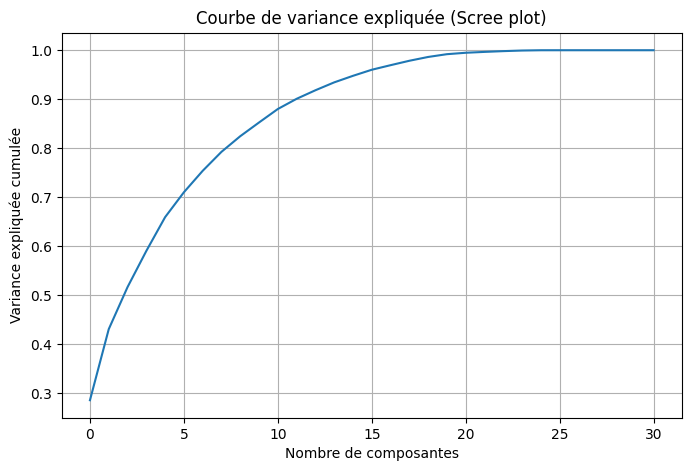

In [33]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Courbe de variance expliquée (Scree plot)')
plt.grid(True)
plt.show()

On observe que la variance atteint 90% et se stabilise quelque peut à partir de 11 composantes. Ainsi, la rétention de 11 composantes principales apparaît comme un compromis optimal entre réduction de dimension et préservation de l’information.

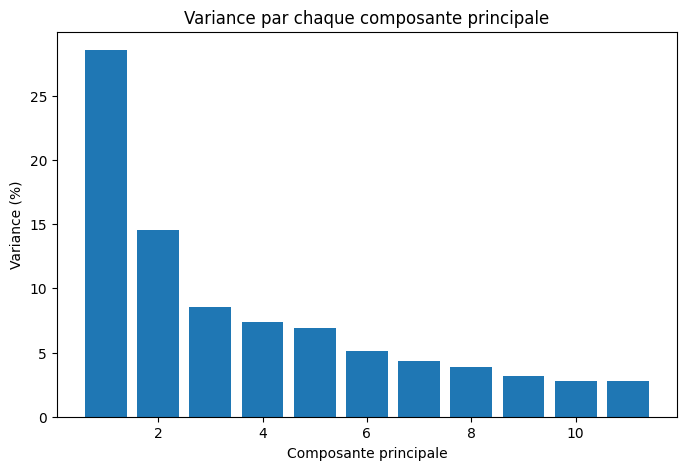

In [34]:
pca = PCA(n_components=11)
pca_result = pca.fit_transform(scaled_dataset)

plt.figure(figsize=(8,5))
plt.bar(range(1, 12), pca.explained_variance_ratio_ * 100)
plt.xlabel('Composante principale')
plt.ylabel('Variance (%)')
plt.title('Variance par chaque composante principale')
plt.show()

On affiche les coefficients de chaque variable originale pour les 10 premières composantes principales (PC1 à PC10).

In [35]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(11)],
    index=ready_dataset_num.columns
)

print(loadings)


                                   PC1           PC2           PC3  \
carbon_wt_pct             1.991506e-01  1.642933e-01  1.907154e-01   
silicon_wt_pct            1.535251e-02 -2.069387e-01  7.136571e-02   
manganese_wt_pct          9.236370e-02 -2.210597e-01  4.425247e-01   
sulphur_wt_pct            2.219284e-01  2.002011e-03 -2.703114e-01   
phosphorus_wt_pct         2.254843e-01  2.199796e-02 -1.693667e-01   
chromium_wt_pct          -1.003486e-01  3.693758e-01  8.401988e-02   
vanadium_wt_pct           3.697680e-02  3.948102e-01  1.598391e-01   
oxygen_ppm               -3.553592e-02  2.014376e-01 -2.091479e-01   
titanium_ppm              4.897380e-02 -1.651534e-01  9.603027e-02   
nitrogen_ppm              2.199566e-02  2.715923e-01  8.049339e-02   
aluminium_ppm             2.581586e-01 -4.557921e-02  3.728077e-02   
niobium_ppm               2.618324e-02  3.588324e-01  8.629777e-02   
current_a                 3.247720e-01  1.851634e-02  6.020172e-02   
voltage_v           

In [36]:
pca = PCA(n_components=11)
pca_result = pca.fit_transform(scaled_dataset)

# Convert the PCA result back to a DataFrame
# This preserves the original index and gives meaningful column names
pca_columns = [f'PC_{i+1}' for i in range(pca.n_components_)]
X_numeric_pca = pd.DataFrame(pca_result, columns=pca_columns, index=ready_dataset_num.index)

# Isolate your original categorical features
X_categorical = ready_dataset[cat_cols].copy()

# Combine the PCA-transformed numerical data and the categorical data
X = pd.concat([X_numeric_pca, X_categorical], axis=1)

In [37]:
print("--- X information ---")
X.info()
print("-"*30)
print("--- Y info ---")
Y.info()

--- X information ---
<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 0 to 1640
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PC_1                  720 non-null    float64
 1   PC_2                  720 non-null    float64
 2   PC_3                  720 non-null    float64
 3   PC_4                  720 non-null    float64
 4   PC_5                  720 non-null    float64
 5   PC_6                  720 non-null    float64
 6   PC_7                  720 non-null    float64
 7   PC_8                  720 non-null    float64
 8   PC_9                  720 non-null    float64
 9   PC_10                 720 non-null    float64
 10  PC_11                 720 non-null    float64
 11  ac_dc_DC              720 non-null    float64
 12  electrode_polarity_-  720 non-null    float64
 13  electrode_polarity_0  720 non-null    float64
 14  weld_type_GMAA        720 non-null    float64
 15  weld_

## Regression Models

Quick test for 3 different models

In [38]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X, Y, cv=cv, scoring="r2")
    print(f"{name:15s}  R² moyen = {scores.mean():.3f}  (±{scores.std():.3f})")


Ridge            R² moyen = 0.550  (±0.061)
RandomForest     R² moyen = 0.644  (±0.072)
GradientBoosting  R² moyen = 0.655  (±0.049)


In [39]:
from sklearn.model_selection import GridSearchCV, KFold

model = GradientBoostingRegressor(random_state=42)

param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0] 
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X, Y) 

print("Best R²:", grid_search.best_score_)
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best R²: 0.6694624043573125
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


Meilleurs hyperparamètres sur Gradient Boost
```python
{
    "learning_rate": 0.05,
    "max_depth": 3,
    "n_estimators": 300,
    "subsample": 0.8
}
```
Best R²: 0.6694624043573125

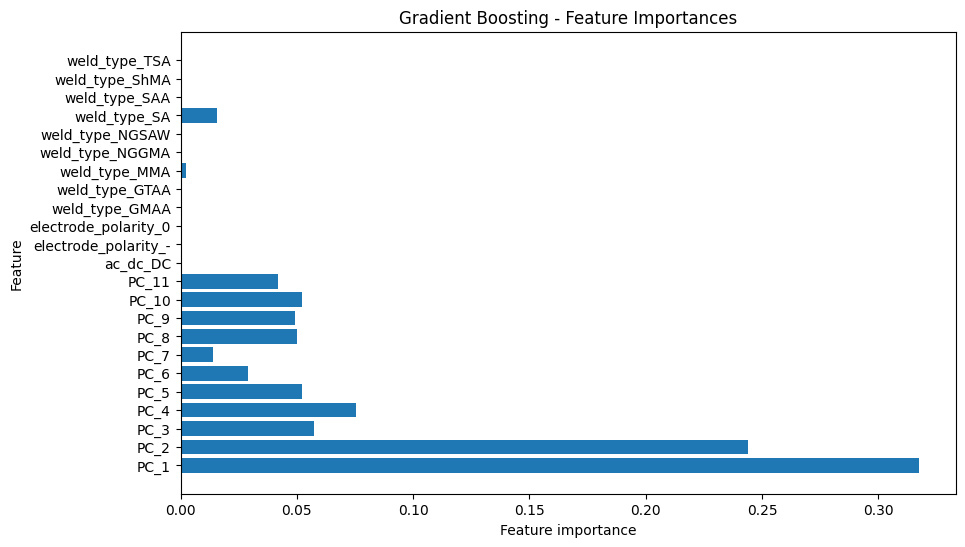

In [40]:
import matplotlib.pyplot as plt

best_params = grid_search.best_params_

model = GradientBoostingRegressor(**best_params, random_state=42)
model.fit(X, Y)
importances = model.feature_importances_

plt.figure(figsize=(10,6))
plt.barh(X.columns, importances)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Gradient Boosting - Feature Importances")
plt.show()

Test avec XGBoost

In [44]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold

# Modèle de base
model = XGBRegressor(random_state=42, verbosity=0, n_jobs=-1)

# Grille d'hyperparamètres
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

# Validation croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

# Entraînement
grid_search.fit(X, Y)

# Résultats
print("Best R²:", grid_search.best_score_)
print("Best params:", grid_search.best_params_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best R²: 0.6884366116383861
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
